In [1]:
import numpy as np
import h5py
from glob import glob 
from tqdm import tqdm
import os

from matplotlib import rc
rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

# #                                                                                                                                       
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})                                                                                             
mpl.rcParams['text.usetex'] = False
mpl.rcParams.update({'xtick.labelsize': 18})
mpl.rcParams.update({'ytick.labelsize': 18})
mpl.rcParams.update({'axes.labelsize': 18})
mpl.rcParams.update({'legend.frameon': False})
mpl.rcParams.update({'lines.linewidth': 2})

import matplotlib.pyplot as plt
import mplhep as hep
hep.set_style(hep.style.CMS)
hep.style.use("CMS")

from matplotlib.lines import Line2D

/tmp/ipykernel_3900327/1845862274.py:29: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


In [2]:
# function for getting histograms from observable values
def calc_hist(vals, bins=10, weights=None, density=True):
    
    if weights is None:
        weights = np.ones(vals.shape)
    
    # compute histogram
    hist, bins = np.histogram(vals, bins=bins, weights=weights)
    
    # compute which bins the values are in
    digits = np.digitize(vals, bins)

    # compute the errors per bin
    # note that lowest bin value that digitize returns is 1
    # hence the range in the following list comprehension should start at 1
    errs = np.asarray([np.linalg.norm(weights[digits==i]) for i in range(1, len(bins))])

    # handle normalization
    if density:
        binwidths = bins[1:] - bins[:-1]
        density_int = weights.sum() * binwidths # (bins[1] - bins[0])
        hist /= density_int
        errs /= density_int
        
    return hist, errs, bins

In [3]:
# get 2004 aleph measurement
# hepData = "/local/d1/badea/e+e-/aleph/data/HEPData-ins636645-v1-Table_54.csv"
# hepData = "/global/cfs/cdirs/m3246/bnachman/LEP/aleph/HEPData-ins636645-v1-Table_54.csv"
hepData = "/home/badea/e+e-/aleph/data/HEPData-ins636645-v1-Table_54.csv"

with open(hepData, 'r') as f:
    
    vals = []
    for row in f:
        if row.startswith('#'):
            continue
            
        if row.startswith('T'):
            print(row.strip())
        else:
            vals.append(row.strip().split(','))
            
hepdata = np.asarray(vals, dtype=float)

aleph_bins = 1 - np.append(1.0, hepdata[::-1,1])
aleph_midbins = (aleph_bins[1:] + aleph_bins[:-1])/2
aleph_thrust = hepdata[::-1,3]
aleph_thrust_errs = np.linalg.norm(hepdata[::-1,[-1,-3,-5]], axis=1)
assert np.all(aleph_bins[1:] == 1 - hepdata[::-1,1]) and np.all(aleph_bins[:-1] == 1 - hepdata[::-1,2])

aleph_log_bins = np.log(aleph_bins + np.exp(-8))
aleph_log_midbins = (aleph_log_bins[1:] + aleph_log_bins[:-1])/2
log_binwidths = aleph_log_bins[1:] - aleph_log_bins[:-1]
aleph_log_thrust = aleph_thrust * 0.01 / log_binwidths
aleph_log_thrust_errs = aleph_thrust_errs * 0.01 / log_binwidths

THRUST,THRUST LOW,THRUST HIGH,(1/SIG)*D(SIG)/DTHRUST,stat +,stat -,sys_1 +,sys_1 -,sys_2 +,sys_2 -


In [4]:
# dataProcessedDir = "/global/cfs/cdirs/m3246/bnachman/LEP/aleph/processed/"
# dataProcessedDir = "/local/d1/badea/e+e-/aleph/data/processed/"
dataProcessedDir = "/home/badea/e+e-/aleph/data/processed/"

# data raw
data = np.load(os.path.join(dataProcessedDir, "data_vals_reco.npy"))
dpass = np.load(os.path.join(dataProcessedDir, "data_pass_reco.npy")).astype(bool)
print(data.shape, dpass.shape, dpass.sum())

# pythia 6 gen
gen = np.load(os.path.join(dataProcessedDir, "MC_vals_truth.npy"))
gpass = np.load(os.path.join(dataProcessedDir, "MC_pass_truth.npy")).astype(bool)
print(gen.shape, gpass.shape, gpass.sum())

# pythia 6 reco
reco = np.load(os.path.join(dataProcessedDir, "MC_vals_reco.npy"))
rpass = np.load(os.path.join(dataProcessedDir, "MC_pass_reco.npy")).astype(bool)
print(reco.shape, rpass.shape, rpass.sum())

(1365440,) (1365440,) 1326351
(973769,) (973769,) 973769
(973769,) (973769,) 751861


In [5]:
# define binning because used next
density = True
bins = aleph_log_bins # np.linspace(-8, np.log(0.5), 50+1)
bin_edges = bins
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2
binwidths = bins[1:] - bins[:-1]

In [6]:
# unfolded results
# steps:
# 1. save all model evaluation weights rather than the finished histogram
# 2. histogram in here all distributions using the correct binning
# 3. plot nominal value
# 4. compute error bars
# 5. plot error bars

# path to unfolded results
# weightsDir = "/global/u1/b/badea/OmniFold/eval/weights/"
# weightsDir = "/local/d1/badea/e+e-/aleph/OmniFold/eval/weights"
# weightsDir = "/home/badea/e+e-/aleph/OmniFold/eval/weights/"

# paths = [
#     ["bootstrap_sim_full", os.path.join(weightsDir, "boot_sim_n_40/*/*.h5")], # bootstrap sim full n=40
#     ["bootstrap_data_full", os.path.join(weightsDir, "phys_weights_n_40/*/*.h5")], # bootstrap data full n=40
#     ["ensemble", os.path.join(weightsDir, "redone_enemble_weights/*.h5")], # ensemble 40
#     ["systematic", "/home/badea/e+e-/aleph/OmniFold/scripts/results/training-1edbafaa/*/omnifold_weights.h5"] # systematic variations
# ]

weightsDir = "/home/badea/e+e-/aleph/OmniFold/scripts/results/"
paths = [
    ["systematic", os.path.join(weightsDir, "training-6d5bf9d4/*/omnifold_weights.h5")], # systematic variations
    ["bootstrap_mc", os.path.join(weightsDir, "training-8379b835/*/omnifold_weights.h5")], # bootstrap mc 
    ["bootstrap_data", os.path.join(weightsDir, "training-45166dfb/*/omnifold_weights.h5")], # bootstrap data
    ["ensemble", os.path.join(weightsDir, "training-315e385c/*/omnifold_weights.h5")], # ensemble
]


# loop over list, histogram, save
u = {}
for key, path in paths:
    fileList = glob(path)
    u[key] = {"counts":[], "errs":[]}
    for fName in tqdm(fileList):
        with h5py.File(fName, "r") as f:
            weights = np.array(f['weights'])
            # unfolded_counts, _ = np.histogram(np.log(1-gen[gpass]), bins=bins, weights = weights[gpass], density=density)
            counts, errs, _ = calc_hist(np.log(1-gen[gpass]), bins=bins, weights=weights[gpass], density=density)
            u[key]["counts"].append(counts)
            u[key]["errs"].append(errs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.27it/s]


In [35]:
# pick one value as the nominal
unfolded_counts = u["bootstrap_data"]["counts"][0]

# compute errors
errs = {}
for key, val in u.items():
    sd = np.std(val["counts"],axis=0)
    ave = np.mean(val["counts"],axis=0)
    sd_over_mean = sd/ave
    errs[key] = sd_over_mean
    
# add in quadrature
unfolded_errs = np.sqrt(np.sum(np.array(list(errs.values()))**2,0)) # LOOK HERE: should this have a sqrt here ... I think no?
unfolded_errs += u["bootstrap_data"]["errs"][0]**2
unfolded_errs = np.sqrt(unfolded_errs)

# scale by central value
unfolded_errs *= unfolded_counts

In [37]:
# to-do: need to get this correction factor
# 06/23/24: AB believes we do not need this because we are reweighting straight to gen before
#           because in dataloader.py we use mc_gen = np.stack(MC["tgenBefore_thrust"]).flatten()
# corrs = genbhist/(genhist + 10**-50)

In [38]:
def propagate_error_division(A, deltaA, B, deltaB):
    """
    Compute the propagated error for division of two quantities A and B with their uncertainties.

    Parameters:
    A (numpy array): Array of values for A.
    deltaA (numpy array): Array of uncertainties for A.
    B (numpy array): Array of values for B.
    deltaB (numpy array): Array of uncertainties for B.

    Returns:
    numpy array: Array of tuples containing (C, deltaC) for corresponding A, deltaA, B, deltaB.
    """
    C = A / B
    deltaC = C * np.sqrt((deltaA / A)**2 + (deltaB / B)**2)
    return deltaC

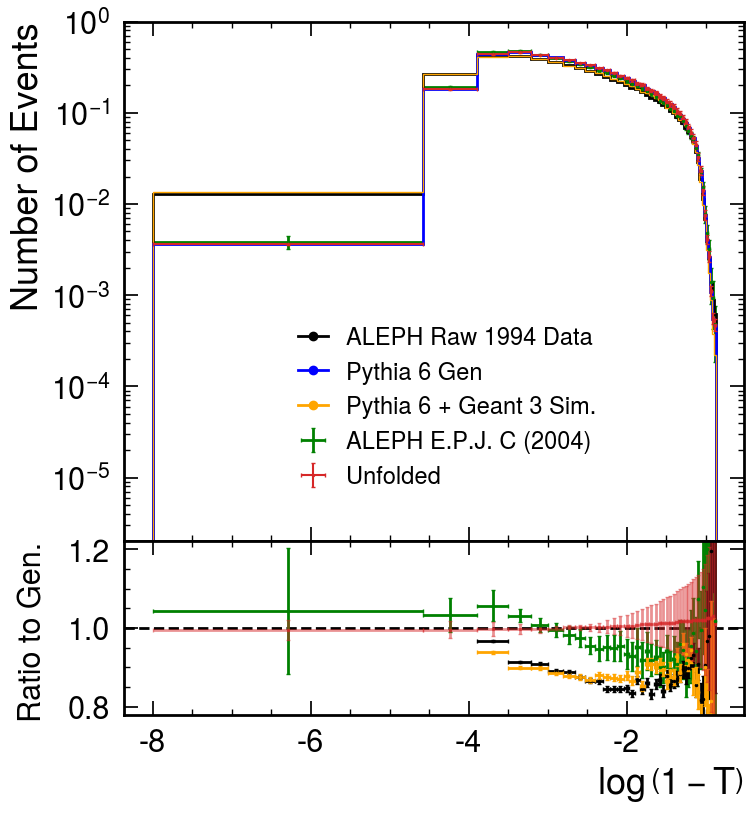

In [39]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,9))
plt.subplots_adjust(hspace=0)

# ALEPH 2004 measurement
ax1.errorbar(aleph_log_midbins, aleph_log_thrust, color='green', label='ALEPH E.P.J. C (2004)', 
             xerr=log_binwidths/2, yerr=aleph_log_thrust_errs, fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# ALEPH raw data
aleph_raw_data_counts, _, _ = ax1.hist(np.log(1-data[dpass]), bins=bins, color='black', label='ALEPH Raw 1994 Data', histtype = 'step', lw=2, zorder= 2, density=density)

# Pythia 6 Gen
gen_counts, _, _ = ax1.hist(np.log(1-gen[gpass]), bins=bins, color='blue', label='Pythia 6 Gen', histtype = 'step', lw=2, zorder= 2, density=density)

# Pythia 6 Reco
reco_counts , _, _ = ax1.hist(np.log(1-reco[rpass]), bins=bins, color='orange', label='Pythia 6 + Geant 3 Sim.', histtype = 'step', density=density)

# Unfolded distribution
ax1.errorbar(midpoints, unfolded_counts, color='tab:red', label='Unfolded', xerr=binwidths/2, yerr=unfolded_errs, 
             fmt='o', lw=1.5, capsize=1.5, capthick=1, markersize=1.5)

ax1.legend()

# Bottom subplot (ratio plot)
ax2.axhline(y=1, color='black', linestyle='--')  # Adding a horizontal line at y=1 for reference

# calculate ratios
# gen_hist_aleph_bins =  np.histogram(np.log(1-gen[gpass]), bins=bins, density=False)

# get gen errors
_, gen_errs, _ = calc_hist(np.log(1-gen[gpass]), bins=bins, density=True)

# # ALEPH 2004 measurement ratio
ax2.errorbar(aleph_log_midbins, aleph_log_thrust/(gen_counts+1e-50), 
             xerr=log_binwidths/2, 
             # yerr=aleph_log_thrust_errs/(gen_counts + 10**-50),
             yerr=propagate_error_division(aleph_log_thrust, aleph_log_thrust_errs, gen_counts, gen_errs),
             color='green', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# ALEPH raw data
_, aleph_raw_data_errs, _ = calc_hist(np.log(1-data[dpass]), bins=bins, density=True)
ax2.errorbar(midpoints, aleph_raw_data_counts/(gen_counts+1e-50), 
             xerr=binwidths/2, 
             # yerr=aleph_raw_data_errs / (gen_counts + 10**-50),
             yerr=propagate_error_division(aleph_raw_data_counts, aleph_raw_data_errs, gen_counts, gen_errs),
             color='black', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# Pythia 6 Reco
_, reco_errs, _ = calc_hist(np.log(1-reco[rpass]), bins=bins, density=True)
ax2.errorbar(midpoints, reco_counts/(gen_counts+1e-50), 
             xerr=binwidths/2, 
             # yerr=reco_errs / (gen_counts + 10**-50),
             yerr=propagate_error_division(reco_counts, reco_errs, gen_counts, gen_errs),
             color='orange', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5)

# Unfolded distribution
ax2.errorbar(midpoints, unfolded_counts/(gen_counts+1e-50), 
             xerr=binwidths/2, 
             # yerr=unfolded_errs / (gen_counts + 10**-50),
             yerr=propagate_error_division(unfolded_counts, unfolded_errs, gen_counts, gen_errs),
             color='tab:red', fmt='o', lw=2, capsize=1.5, capthick=1, markersize=1.5, alpha=0.5)

# tick params
tick_params_major = {"which"     : "major",
                     "length"    : 10,
                     "width"     : 1.25,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 22,
                     "pad"       : 10}
tick_params_minor = {"which"     : "minor",
                     "length"    : 4,
                     "width"     : 1,
                     "direction" : "in",
                     "right"     : True,
                     "top"       : True,
                     "labelsize" : 18}
ax1.tick_params(**tick_params_major)
ax1.tick_params(**tick_params_minor)
ax2.tick_params(**tick_params_major)
ax2.tick_params(**tick_params_minor)

# set limits
ax1.set_ylim(0.2*10**-5, 10**0)
# ax2.set_xlim(-10,0)
ax2.set_ylim(0.78,1.22)

# log scale
ax1.set_yscale("log")

# axis labels
ax1.set_ylabel("Number of Events") #r'Number of $\tilde{\eta}$ decays/Event')
ax2.set_ylabel("Ratio to Gen.", fontsize=22, labelpad=14)
ax2.set_xlabel(r'$\log\left(1-T\right)$')

# legend
handles, labels = ax1.get_legend_handles_labels()
new_handles = []
for h in handles:
    try:
        new_handles.append(Line2D([], [], linestyle='-', marker='o', c=h.get_edgecolor()))
    except:
        new_handles.append(h)
            
ax1.legend(new_handles,
          labels,
          title="",
          title_fontsize="13",
          ncol=1,
          framealpha=0.0,
          prop={'size': 17},
          bbox_to_anchor=(0.35, 0.01, 0.45, 0.45), #(0.54, 0.45, 0.45, 0.5)
          handlelength=1.25)

# add text
# left, top, t = 0.07, 0.94, 0.06
# stamps = [
#     r"higgs portal, $pp \rightarrow h \rightarrow q_{d}q_{d} \; (q_{d} \rightarrow (dark) \; hadrons)$",
#     "arxiv:2103.01238",
#     r"$\mathit{m_{\tilde{\omega}}} = \mathit{m_{\tilde{\eta}}}$",
#     r"$c\tau = 30\; mm \times \left(\frac{5 \; GeV}{\mathit{m_{\tilde{\eta}}}}\right)^{7}$", #  # 5 \; GeV / \mathit{m_{\tilde{\eta}}}
#     r"$L_{xy} < 1000\; mm$",
#     r"$\mathrm{p_{T}}$ > 5 GeV, |$\eta$|<2.4",
# ]
# for i, stamp in enumerate(stamps):
#     ax1.text(left, top - i*t, stamp, fontsize=14, ha='left', va='top', transform=ax1.transAxes)

# save
plt.savefig("log(tau)_new.pdf", bbox_inches="tight")

In [25]:
print(errs.keys())
for key, val in u.items():
    # sd = np.std(val["counts"],axis=0)
    # ave = np.mean(val["counts"],axis=0)
    print(key, np.std(val["counts"],axis=0).shape)

print(np.array(list(errs.values())).shape)
print(np.sum(np.array(list(errs.values()))**2,0).shape)
# np.sqrt(np.sum(np.array(list(errs.values()))**2,0))
temp = np.sum(np.array(list(errs.values()))**2,0)
print(temp)
temp += u["bootstrap_data"]["errs"][0]**2
# temp = temp**2 + u["bootstrap_data"]["errs"][0]**2
print(temp.sum())
temp = np.sqrt(temp)
print(temp.sum())

dict_keys(['systematic', 'bootstrap_mc', 'bootstrap_data', 'ensemble'])
systematic (42,)
bootstrap_mc (42,)
bootstrap_data (42,)
ensemble (42,)
(4, 42)
(42,)
[5.8285409e-04 4.3999718e-04 3.0246426e-04 1.8094665e-04 8.9532768e-05
 3.0553012e-05 4.2819347e-06 9.6586773e-06 4.8311511e-05 1.1805961e-04
 2.1637409e-04 3.5137843e-04 5.1871402e-04 7.1727397e-04 9.4180007e-04
 1.2100997e-03 1.5047790e-03 1.8341141e-03 2.1848818e-03 2.5659623e-03
 2.9939304e-03 3.4451464e-03 3.9353818e-03 4.4244970e-03 5.0356565e-03
 5.5660121e-03 6.1865686e-03 6.8468917e-03 7.5379461e-03 8.2543874e-03
 8.9713205e-03 9.7897965e-03 1.0585112e-02 1.1440664e-02 1.2321209e-02
 1.3256099e-02 1.4214084e-02 1.5208463e-02 1.6217999e-02 1.7364843e-02
 1.8500390e-02 1.9783955e-02]
0.23582059
2.5792625


(4, 42)
dict_keys(['systematic', 'bootstrap_mc', 'bootstrap_data', 'ensemble'])
(42,)


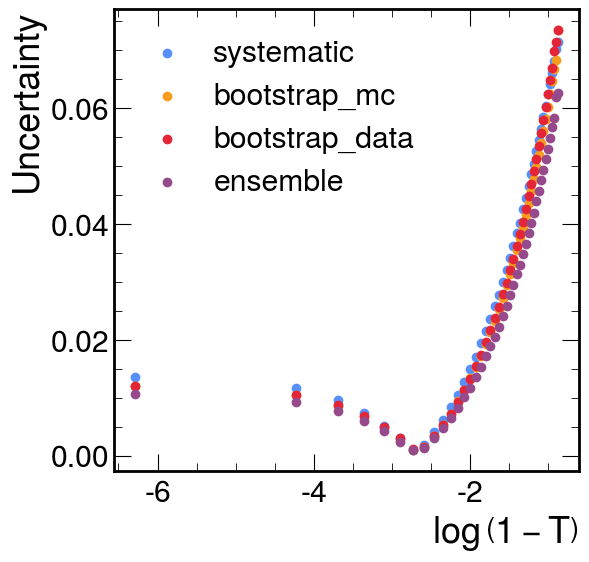

In [40]:
# unfolded_errs = np.sqrt(np.sum(np.array(list(errs.values()))**2,0))
# unfolded_errs += u["bootstrap_data"]["errs"][0]**2
# unfolded_errs = np.sqrt(unfolded_errs)

temp = np.array(list(errs.values()))
print(temp.shape)
print(errs.keys())
print(midpoints.shape)
# Plotting

plt.figure(figsize=(6,6))
for key, val in errs.items():
    plt.scatter(midpoints, val, label=key)
plt.xlabel(r'$\log\left(1-T\right)$')
plt.ylabel("Uncertainty")
plt.legend()


# save
plt.savefig("uncertainty_breakdown.pdf", bbox_inches="tight")